In [1]:
import pandas as pd

# Read the Excel file
df = pd.read_excel("lottery_numbers.xlsx")

# Extract the last 2 digits from each number in the range A1:J100
lottery_list = df.applymap(lambda x: str(x)[-2:]).values.flatten().tolist()

print(lottery_list)

['76', '34', '84', '50', '64', '40', '35', '60', '39', '94', '46', '44', '50', '66', '36', '29', '54', '24', '35', '08', '03', '02', '08', '05', '26', '18', '09', '61', '40', '49', '90', '12', '86', '57', '52', '63', '62', '68', '73', '55', '74', '77', '45', '98', '32', '95', '43', '53', '80', '09', '94', '65', '86', '51', '46', '35', '38', '64', '79', '29', '68', '32', '66', '44', '59', '96', '23', '13', '07', '07', '90', '00', '18', '80', '66', '26', '17', '43', '90', '50', '80', '02', '06', '13', '17', '77', '04', '15', '91', '63', '35', '40', '89', '84', '55', '92', '11', '32', '46', '81', '42', '52', '74', '00', '92', '03', '45', '20', '11', '88', '88', '40', '96', '40', '05', '74', '86', '80', '59', '73', '38', '28', '80', '05', '51', '70', '73', '63', '08', '18', '43', '66', '87', '17', '21', '32', '17', '63', '01', '90', '85', '11', '02', '14', '61', '10', '28', '12', '69', '58', '62', '96', '29', '05', '44', '06', '42', '20', '95', '39', '43', '65', '69', '78', '87', '61', '40

C:\Users\Kolawat\AppData\Local\Temp\ipykernel_21540\1228951775.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lottery_list = df.applymap(lambda x: str(x)[-2:]).values.flatten().tolist()


In [4]:
from collections import Counter

# Count the frequency of each number
frequency_count = Counter(lottery_numbers)

# Convert the frequency count to a DataFrame
frequency_df = pd.DataFrame(list(frequency_count.items()), columns=['Number', 'Frequency'])

# Sort the DataFrame by Number
frequency_df = frequency_df.sort_values(by='Number').reset_index(drop=True)

frequency_df

,Number,Frequency
0,0,9
1,1,10
2,2,13
3,3,9
4,4,9
...,...,...
95,95,10
96,96,8
97,97,6
98,98,11


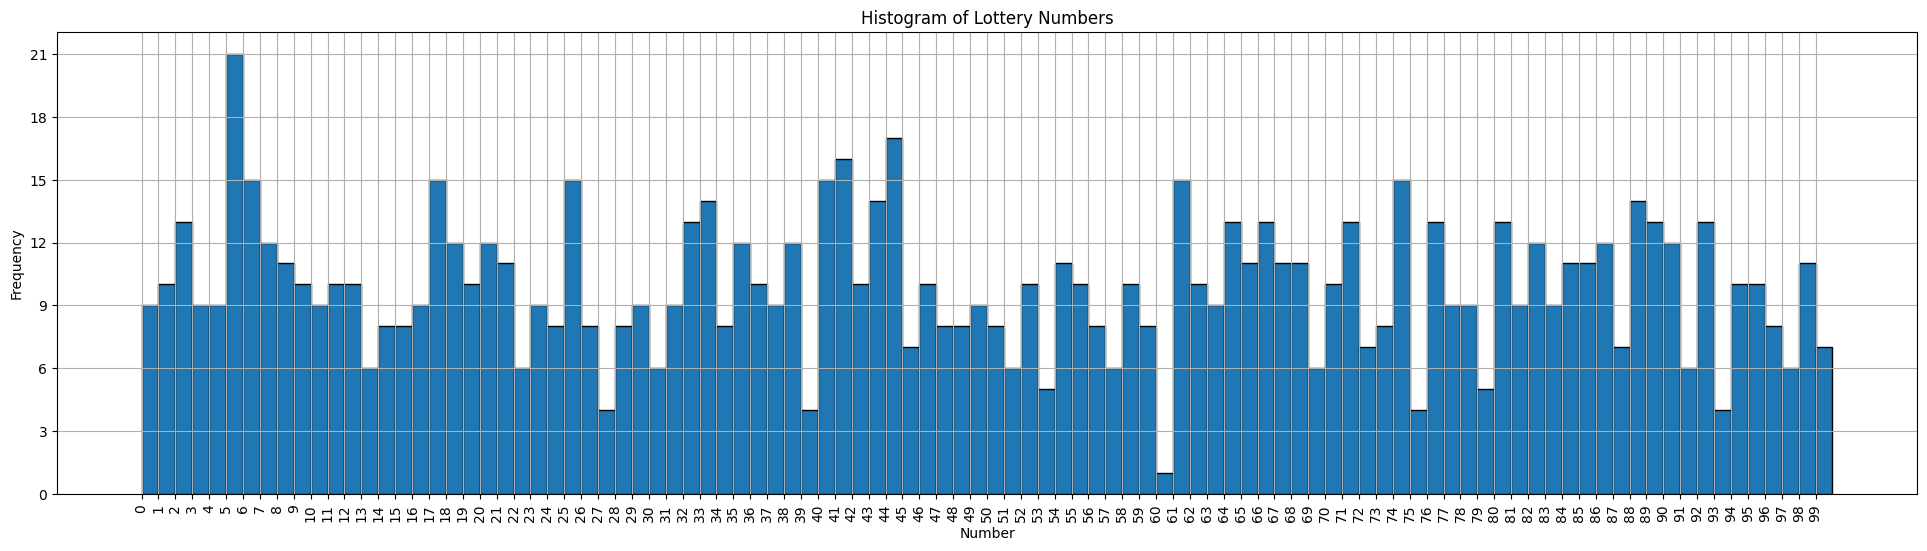

In [9]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

# Convert the lottery_list to integers
lottery_numbers = list(map(int, lottery_list))

# Plot the histogram with a larger figure size
plt.figure(figsize=(24, 6))
plt.hist(lottery_numbers, bins=range(101), edgecolor='black')
plt.xlabel('Number')
plt.ylabel('Frequency')
plt.title('Histogram of Lottery Numbers')
plt.xticks(range(0, 100, 5))  # Set x-ticks at intervals of 5
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True)

# Display the numbers on the x-axis with rotation to avoid overlap
plt.xticks(range(0, 100, 1), rotation=90)

plt.show()